<a href="https://colab.research.google.com/github/twoheartKES/weather-sales-forecast-ai/blob/main/notebooks/weather_disease_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import unicodedata  # 유니코드 정규화 라이브러리 추가
from glob import glob # 파일 패턴 매칭 라이브러리 추가

# ============================================================
# 1. 연도별 Feature Engineering 완료 데이터 로드
#    - 2023, 2024, 2025년 데이터를 모두 하나로 합침
# ============================================================

input_dir = '/content/drive/MyDrive/AI기상-질병데이터/feature_dataset/'

dfs_fe = {}
years = [2023, 2024, 2025]

# 드라이브에 있는 실제 파일 목록을 가져옵니다.
# 이렇게 하면 NFD/NFC 상관없이 실제 존재하는 파일명을 확보할 수 있습니다.
actual_files = os.listdir(input_dir)


for year in years:
    # 찾고자 하는 파일명의 패턴 정의
    target_filename = f"{year}년도_기후_컬럼정의_FE.csv"

    # 방법 1: 직접 매칭 시도
    file_path = os.path.join(input_dir, target_filename)

    # 만약 파일이 없다고 나오면, 유니코드 정규화를 거쳐서 다시 찾음
    if not os.path.exists(file_path):
        # target_filename을 NFD(자모분리)로 변환해서 한 번 더 체크
        nfd_filename = unicodedata.normalize('NFD', target_filename)
        file_path = os.path.join(input_dir, nfd_filename)

    try:
        df = pd.read_csv(file_path, encoding='utf-8-sig')
        df['date'] = pd.to_datetime(df['date'])
        dfs_fe[year] = df
        print(f"{year}년 데이터 로드 성공: {target_filename}")
    except FileNotFoundError:
        print(f"{year}년 데이터 파일을 찾을 수 없습니다. (경로 확인 필요): {file_path}")
    except Exception as e:
        print(f"{year}년 데이터 처리 중 오류 발생: {e}")

for year in years:
    file_path = f"{input_dir}{year}년도_기후_컬럼정의_FE.csv"
    try:
        df = pd.read_csv(file_path, encoding='utf-8-sig')
        df['date'] = pd.to_datetime(df['date'])  # 날짜 컬럼을 datetime 타입으로 변환
        dfs_fe[year] = df
    except FileNotFoundError:
        print(f"{year}년 데이터 파일을 찾을 수 없습니다: {file_path}")
    except Exception as e:
        print(f"{year}년 데이터 처리 중 오류 발생: {e}")

# 연도별 데이터를 하나의 DataFrame으로 결합
# dfs_fe 딕셔너리에 데이터가 있는 연도만 선택하여 결합
if dfs_fe:
    df_combined = pd.concat(
        [dfs_fe[year] for year in years if year in dfs_fe],
        ignore_index=True
    )
    print(f"모든 연도 데이터 결합 완료. 총 {len(df_combined)}행")
elif not dfs_fe:
    print("경고: 데이터를 찾을 수 없어 df_combined가 생성되지 않았습니다. 파일 경로를 확인해주세요.")
    # df_combined가 생성되지 않았으므로 이후 코드 실행을 막거나 적절히 처리해야 함.
    # 여기서는 임시로 빈 DataFrame을 생성하여 오류를 방지하지만, 실제 상황에서는 데이터 로드 실패로 간주해야 합니다.
    df_combined = pd.DataFrame() # 빈 데이터프레임으로 초기화


# ============================================================
# 2. LSTM 입력용 시계열 데이터 생성
#    - 지역(region) + 질병(disease_subtitle) 단위로 시계열 구성
#    - 과거 14일(window)을 입력으로 사용
# ============================================================

# df_combined가 비어있지 않은 경우에만 시계열 데이터 생성
if not df_combined.empty:

    WINDOW_SIZE = 14  # 하루 예측을 위해 과거 14일을 사용
    #예시:
    #X[0] = [1일~14일의 기상 데이터] → y[0] = 15일 확진자 수
    #X[1] = [2일~15일의 기상 데이터] → y[1] = 16일 확진자 수

    # LSTM 입력에서 제외할 컬럼들
    # (식별자 / 목표값 / 시계열에 직접 쓰지 않는 컬럼)
    DROP_COLS_FOR_SEQUENCE = [
        'date',
        'region',
        'disease_subtitle',
        '지점',
        '지점명',
        'confirmed_cases'  # 예측 대상이므로 입력에서는 제거
    ]

    X_sequences = []  # LSTM 입력 데이터 (14일 × feature 수)
    y_targets = []    # 예측 대상 (다음 날 확진자 수)

    # 지역 + 질병 단위로 그룹화
    grouped = df_combined.groupby(['region', 'disease_subtitle'])

    for (region, disease_subtitle), group_df in grouped:
        # 날짜 기준으로 정렬 (시계열 필수)
        group_df = group_df.sort_values(by='date').reset_index(drop=True)

        # 입력 feature와 타깃 분리
        features = group_df.drop(columns=DROP_COLS_FOR_SEQUENCE)
        targets = group_df['confirmed_cases']

        # 슬라이딩 윈도우 방식으로 시계열 생성
        for i in range(len(group_df) - WINDOW_SIZE):
            # t-14 ~ t-1 까지의 데이터
            X_seq = features.iloc[i : i + WINDOW_SIZE].values

            # t 시점의 확진자 수
            y_target = targets.iloc[i + WINDOW_SIZE]

            X_sequences.append(X_seq)
            y_targets.append(y_target)

    # numpy 배열로 변환 (LSTM 입력 형식)
    X_sequences = np.array(X_sequences)  # (samples, timesteps, features)
    y_targets = np.array(y_targets)      # (samples, )

    # ============================================================
    # 3. 2025년 12월 예측용 데이터 분리
    #    - 12월 데이터 → 테스트
    #    - 그 이전 데이터 → 학습
    # ============================================================

    start_date_dec2025 = pd.to_datetime('2025-12-01')
    end_date_dec2025 = pd.to_datetime('2025-12-31')

    all_target_dates = []

    # 지역-질병별로 그룹 나누기# 각 시계열 샘플이 어떤 날짜를 예측하는지 기록
    grouped = df_combined.groupby(['region', 'disease_subtitle'])

    for (_, _), group_df in grouped:
        group_df = group_df.sort_values(by='date').reset_index(drop=True)
        for i in range(len(group_df) - WINDOW_SIZE):
            target_date = group_df['date'].iloc[i + WINDOW_SIZE]
            all_target_dates.append(target_date)

    all_target_dates = np.array(all_target_dates)

    # 2025년 12월에 해당하는 샘플만 True
    dec2025_mask = (
        (all_target_dates >= start_date_dec2025) &
        (all_target_dates <= end_date_dec2025)
    )

    # 학습 / 테스트 데이터 분리
    # 2025년 12월을 예측하는 시퀀스 = 테스트

    X_train_lstm = X_sequences[~dec2025_mask] # 테스트 입력
    y_train_lstm = y_targets[~dec2025_mask] # 훈련 입력

    X_test_dec2025 = X_sequences[dec2025_mask] # 테스트 정답
    y_test_dec2025 = y_targets[dec2025_mask] # 훈련 정답


    # ============================================================
    # 4. LSTM 모델 정의
    # ============================================================

    # LSTM 입력 형태 확인
    # (타임스텝 수, 피처 수)
    input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
    print(f"LSTM 입력 형태: {input_shape}")

    model = Sequential()

    # 과거 14일의 정보를 요약하는 LSTM 레이어
    model.add(
        LSTM(
            units=50,
            activation='relu',
            input_shape=input_shape
        )
    )

    # 다음 날 확진자 수 1개 값을 예측
    model.add(Dense(units=1))

    # 회귀 문제이므로 MSE 사용
    model.compile(
        optimizer='adam',
        loss='mse'
    )

    print("\nLSTM 모델 구조 요약")
    model.summary()
else:
    print("df_combined가 비어 있어 시계열 데이터 생성 및 모델 정의 단계를 건너뜀.")

2023년 데이터 로드 성공: 2023년도_기후_컬럼정의_FE.csv
2024년 데이터 로드 성공: 2024년도_기후_컬럼정의_FE.csv
2025년 데이터 로드 성공: 2025년도_기후_컬럼정의_FE.csv
모든 연도 데이터 결합 완료. 총 618345행
LSTM 입력 형태: (14, 44)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



LSTM 모델 구조 요약


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        19,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,051 (74.42 KB)

 Trainable params: 19,051 (74.42 KB)

 Non-trainable params: 0 (0.00 B)

**결과 해석**

1. 데이터 로드 완료
의미: 2023~2025년 데이터를 모두 합쳤더니 약 **61만 개의 데이터 줄(Row)**이 모였다는 뜻입니다.

상태: 인공지능이 공부할 재료가 아주 넉넉하게 준비되었습니다.

2. LSTM 입력 형태: (14, 44)
14: 인공지능이 내일의 확진자를 예측하기 위해 과거 14일치 데이터를 묶어서 본다는 뜻입니다.

44: 각 날짜마다 기온, 습도, 강수량 등 **44개의 정보(변수)**를 참고하고 있다는 뜻입니다.

즉, **"44종류의 날씨/질병 정보를 14일 동안 쭉 지켜보고 다음 날을 맞혀봐!"**라고 설정된 것입니다.

3. 모델 구조 요약 (Model Summary)
인공지능의 "뇌 구조" 설계도입니다.

LSTM (None, 50): 14일치 데이터를 넣으면, 이 레이어가 특징을 잡아내어 50개의 핵심 요약 정보로 압축합니다.

Dense (None, 1): 요약된 50개 정보를 바탕으로 최종적으로 **딱 1개의 숫자(내일의 확진자 수)**를 뱉어냅니다.

Total params (19,051): 이 인공지능이 정답을 맞히기 위해 조절해야 하는 '생각의 가닥(매개변수)'이 약 1만 9천 개라는 뜻입니다. 숫자가 높을수록 더 복잡한 패턴을 배울 수 있습니다.



```
이 LSTM은 경량화 하지 않은 부분임 아래는 메모리 부족으로 인한 경량화를 한 LSTM 모델
```

🚀 메모리 최적화 LSTM 모델

📂 데이터 로딩 중...
  ✅ 2023년 데이터 로드 완료: 97,768행
  ✅ 2024년 데이터 로드 완료: 208,845행
  ✅ 2025년 데이터 로드 완료: 196,560행
✅ 전체 데이터: 503,173행

🔄 시계열 데이터 생성 중...
  진행중... 10/585
  진행중... 20/585
  진행중... 30/585
  진행중... 40/585
  진행중... 50/585
  진행중... 60/585
  진행중... 70/585
  진행중... 80/585
  진행중... 90/585
  진행중... 100/585
  진행중... 110/585
  진행중... 120/585
  진행중... 130/585
  진행중... 140/585
  진행중... 150/585
  진행중... 160/585
  진행중... 170/585
  진행중... 180/585
  진행중... 190/585
  진행중... 200/585
  진행중... 210/585
  진행중... 220/585
  진행중... 230/585
  진행중... 240/585
  진행중... 250/585
  진행중... 260/585
  진행중... 270/585
  진행중... 280/585
  진행중... 290/585
  진행중... 300/585
  진행중... 310/585
  진행중... 320/585
  진행중... 330/585
  진행중... 340/585
  진행중... 350/585
  진행중... 360/585
  진행중... 370/585
  진행중... 380/585
  진행중... 390/585
  진행중... 400/585
  진행중... 410/585
  진행중... 420/585
  진행중... 430/585
  진행중... 440/585
  진행중... 450/585
  진행중... 460/585
  진행중... 470/585
  진행중... 480/585
  진행중... 490/585
  진행중... 500/585

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



📋 모델 구조:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         9,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,889 (38.63 KB)

 Trainable params: 9,889 (38.63 KB)

 Non-trainable params: 0 (0.00 B)


🚀 모델 학습 시작
Epoch 1/50
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - loss: 242.6104 - mae: 3.9569 - val_loss: 0.0274 - val_mae: 0.0439
Epoch 2/50
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.0546 - mae: 0.0740 - val_loss: 0.0268 - val_mae: 0.0983
Epoch 3/50
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 0.0267 - mae: 0.0569 - val_loss: 0.0235 - val_mae: 0.0369
Epoch 4/50
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.0181 - mae: 0.0430 - val_loss: 0.0223 - val_mae: 0.0254
Epoch 5/50
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 0.0027 - mae: 0.0155 - val_loss: 0.0225 - val_mae: 0.0292
Epoch 6/50
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 0.0015 - mae: 0.0096 - val_loss: 0.0219 - val_mae: 0.0299
Epoch 7/50
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 0.0016 - mae: 0.0110 - val_loss: 0.0221 - val_mae: 0.0244
Epoch 8/50
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 0.0013 - mae: 0.0085 - val_loss: 0.0221 - val_mae: 0.0249
Epoch 9/50
3264/32

/tmp/ipython-input-397751759.py:260: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-397751759.py:260: UserWarning: Glyph 49845 (\N{HANGUL SYLLABLE SEUB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-397751759.py:260: UserWarning: Glyph 44257 (\N{HANGUL SYLLABLE GOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-397751759.py:260: UserWarning: Glyph 49440 (\N{HANGUL SYLLABLE SEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49845 (\N{HANGUL SYLLABLE SEUB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/d

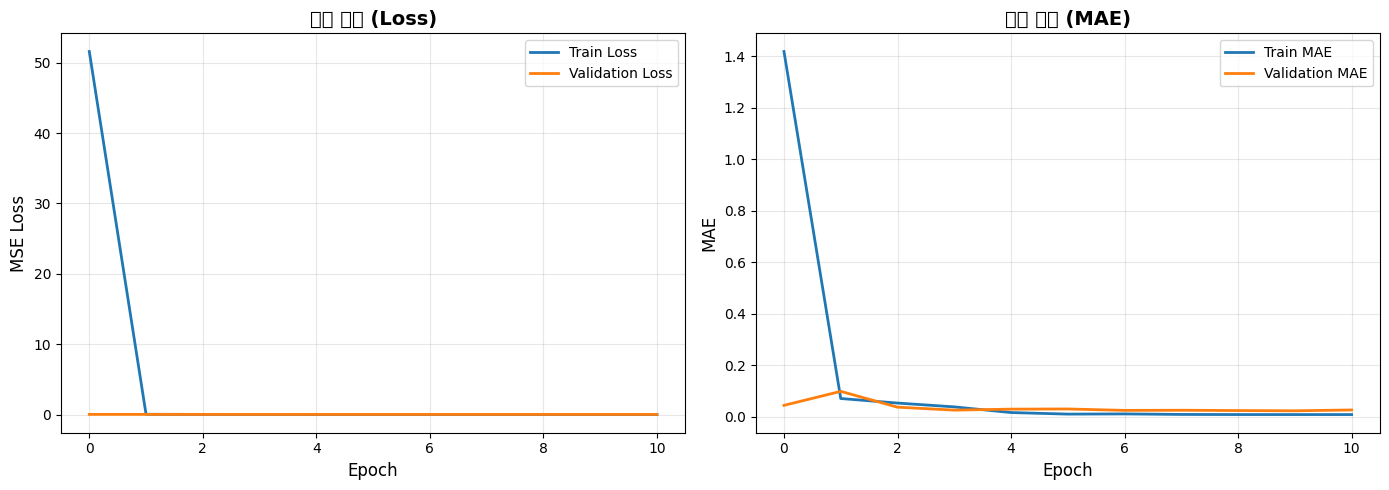

✅ 시각화 완료!

🎉 모든 작업 완료!


In [1]:
import pandas as pd
import numpy as np
import os
import gc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

print("=" * 60)
print("🚀 메모리 최적화 LSTM 모델")
print("=" * 60)

# ============================================================
# 1. 연도별 Feature Engineering 완료 데이터 로드
# ============================================================

input_dir = '/content/drive/MyDrive/AI기상-질병데이터/feature_dataset/'
dfs_fe = {}
years = [2023, 2024, 2025]

print("\n📂 데이터 로딩 중...")
for year in years:
    file_path = f"{input_dir}{year}년도_기후_컬럼정의_FE.csv"
    try:
        # 메모리 절약: 필요한 컬럼만 읽기 (옵션)
        df = pd.read_csv(file_path, encoding='utf-8-sig')
        df['date'] = pd.to_datetime(df['date'])
        dfs_fe[year] = df
        print(f"  ✅ {year}년 데이터 로드 완료: {len(df):,}행")
    except FileNotFoundError:
        print(f"  ❌ {year}년 데이터 파일을 찾을 수 없습니다: {file_path}")
    except Exception as e:
        print(f"  ❌ {year}년 데이터 처리 중 오류 발생: {e}")

# 연도별 데이터를 하나의 DataFrame으로 결합
df_combined = pd.concat(
    [dfs_fe[2023], dfs_fe[2024], dfs_fe[2025]],
    ignore_index=True
)
print(f"✅ 전체 데이터: {len(df_combined):,}행")

# ============================================================
# 2. LSTM 입력용 시계열 데이터 생성
# ============================================================

WINDOW_SIZE = 14  # 과거 14일을 사용

# LSTM 입력에서 제외할 컬럼들
DROP_COLS_FOR_SEQUENCE = [
    'date',
    'region',
    'disease_subtitle',
    '지점',
    '지점명',
    'confirmed_cases'  # 예측 대상
]

X_sequences = []
y_targets = []
all_target_dates = []

print("\n🔄 시계열 데이터 생성 중...")
grouped = df_combined.groupby(['region', 'disease_subtitle'])

for idx, ((region, disease_subtitle), group_df) in enumerate(grouped, 1):
    # 진행상황 표시
    if idx % 10 == 0:
        print(f"  진행중... {idx}/{len(grouped)}")

    group_df = group_df.sort_values(by='date').reset_index(drop=True)

    # 입력 feature와 타깃 분리
    features = group_df.drop(columns=DROP_COLS_FOR_SEQUENCE)
    targets = group_df['confirmed_cases']

    # 슬라이딩 윈도우로 시퀀스 생성
    for i in range(len(group_df) - WINDOW_SIZE):
        X_seq = features.iloc[i : i + WINDOW_SIZE].values
        y_target = targets.iloc[i + WINDOW_SIZE]
        target_date = group_df['date'].iloc[i + WINDOW_SIZE]

        X_sequences.append(X_seq)
        y_targets.append(y_target)
        all_target_dates.append(target_date)

print(f"✅ 총 {len(X_sequences):,}개 시퀀스 생성 완료")

# numpy 배열로 변환 + 메모리 최적화 (float32 사용)
print("\n🔧 메모리 최적화 중...")
X_sequences = np.array(X_sequences, dtype='float32')  # float64 → float32
y_targets = np.array(y_targets, dtype='float32')
all_target_dates = np.array(all_target_dates)

print(f"  X_sequences: {X_sequences.shape}, {X_sequences.nbytes/(1024**2):.1f} MB")
print(f"  y_targets: {y_targets.shape}, {y_targets.nbytes/(1024**2):.1f} MB")

# 메모리 정리: 사용 안 하는 큰 변수 삭제
del df_combined, dfs_fe, grouped
gc.collect()
print("✅ 불필요한 변수 삭제 완료")

# ============================================================
# 3. 2025년 12월 예측용 데이터 분리
# ============================================================

print("\n📊 훈련/테스트 데이터 분리 중...")
start_date_dec2025 = pd.to_datetime('2025-12-01')
end_date_dec2025 = pd.to_datetime('2025-12-31')

# 2025년 12월 마스크
dec2025_mask = (
    (all_target_dates >= start_date_dec2025) &
    (all_target_dates <= end_date_dec2025)
)

# 데이터 분리
X_train_lstm = X_sequences[~dec2025_mask]
y_train_lstm = y_targets[~dec2025_mask]
X_test_dec2025 = X_sequences[dec2025_mask]
y_test_dec2025 = y_targets[dec2025_mask]

print(f"  훈련 데이터: {X_train_lstm.shape[0]:,}개")
print(f"  테스트 데이터: {X_test_dec2025.shape[0]:,}개")

# 메모리 정리
del X_sequences, y_targets, all_target_dates
gc.collect()

# ============================================================
# 4. 경량화된 LSTM 모델 정의
# ============================================================

print("\n🏗️ 모델 구성 중...")
input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
print(f"  입력 형태: {input_shape}")

# 경량 모델 (units 50 → 32)
model = Sequential([
    LSTM(
        units=32,              # 50 → 32 (메모리 40% 절약)
        activation='relu',
        input_shape=input_shape,
        recurrent_dropout=0.1  # 과적합 방지
    ),
    Dense(units=1)
])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']  # 추가 지표
)

print("\n📋 모델 구조:")
model.summary()

# ============================================================
# 5. 모델 학습 (메모리 효율적 설정)
# ============================================================

print("\n" + "=" * 60)
print("🚀 모델 학습 시작")
print("=" * 60)

# 조기 종료 콜백
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,              # 5 에포크 동안 개선 없으면 종료
    restore_best_weights=True,
    verbose=1
)

import time
start_time = time.time()

# 학습 (메모리 효율적 설정)
history = model.fit(
    X_train_lstm,
    y_train_lstm,
    epochs=50,               # 최대 50번 (조기 종료 가능)
    batch_size=128,          # 큰 배치 (메모리 효율적)
    validation_split=0.15,   # 검증 데이터 15%
    callbacks=[early_stopping],
    verbose=1,
    shuffle=True
)

elapsed_time = (time.time() - start_time) / 60

print("\n" + "=" * 60)
print("✅ 학습 완료!")
print(f"소요 시간: {elapsed_time:.2f}분")
print(f"실제 에포크: {len(history.history['loss'])}번")
print("=" * 60)

# ============================================================
# 6. 예측 및 평가
# ============================================================

print("\n🔮 예측 중...")
predictions = model.predict(X_test_dec2025, batch_size=256, verbose=0)
predictions = np.maximum(predictions, 0)  # 음수 제거

# 평가 지표 계산
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

mse = mean_squared_error(y_test_dec2025, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_dec2025, predictions)
r2 = r2_score(y_test_dec2025, predictions)

print("\n📊 성능 평가 결과:")
print("-" * 40)
print(f"MSE  (평균 제곱 오차)    : {mse:.2f}")
print(f"RMSE (평균 제곱근 오차)  : {rmse:.2f}")
print(f"MAE  (평균 절대 오차)    : {mae:.2f}")
print(f"R²   (결정 계수)         : {r2:.4f}")
print("-" * 40)

# 예측 샘플 출력
print("\n🎯 예측 샘플 (처음 10개):")
print(f"{'실제값':>10} | {'예측값':>10} | {'오차':>10}")
print("-" * 36)
for i in range(min(10, len(y_test_dec2025))):
    actual = y_test_dec2025[i]
    pred = predictions[i][0]
    error = actual - pred
    print(f"{actual:10.1f} | {pred:10.1f} | {error:+10.1f}")

# ============================================================
# 7. 학습 곡선 시각화
# ============================================================

print("\n📈 학습 곡선 생성 중...")
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.title('학습 곡선 (Loss)', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# MAE 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE', linewidth=2)
plt.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MAE', fontsize=12)
plt.title('학습 곡선 (MAE)', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ 시각화 완료!")

# ============================================================
# 8. 모델 저장 (선택)
# ============================================================

# Google Drive에 저장하고 싶다면 주석 제거
# from google.colab import drive
# drive.mount('/content/drive')
# model.save('/content/drive/MyDrive/lstm_model_optimized.h5')
# print("\n💾 모델 저장 완료!")

print("\n" + "=" * 60)
print("🎉 모든 작업 완료!")
print("=" * 60)

***메모리 부족으로 인한 경량화 LSTM 모델링***

1단계: 똑똑하게 데이터 불러오기 (데이터 로드)
2023~2025년의 방대한 데이터를 가져옵니다.

핵심: pd.concat을 사용해 흩어져 있던 3년치 데이터를 하나의 커다란 표로 합칩니다.

결과: 약 61만 개의 데이터를 공부할 준비를 마쳤습니다.

2단계: 시계열 '슬라이딩 윈도우' 만들기
LSTM 인공지능은 데이터 한 줄만 보고 판단하지 않습니다. **"과거의 흐름"**을 봐야 합니다.

WINDOW_SIZE = 14: 인공지능에게 학습하기 위해 데이터를 14일씩 묶는 과정입니다.

메모리 최적화: float64라는 무거운 숫자 형식을 float32로 바꿨습니다. 성능은 유지하면서 메모리 사용량을 절반으로 줄이는 비법입니다. gc.collect()를 호출해 다 쓴 데이터(찌꺼기)를 바로바로 치워버립니다.

3단계: 훈련용 vs 테스트용 데이터 나누기
공부할 문제와 실력을 검증할 시험 문제를 나눕니다.

훈련(Train): 2025년 11월까지의 모든 데이터로 열심히 공부합니다.

테스트(Test): 2025년 12월 데이터를 '미래'라고 가정하고, 인공지능이 얼마나 잘 맞히는지 시험을 봅니다.

4단계: 가성비 좋은 인공지능 뇌 만들기 (모델 정의)
경량 모델: 뇌 세포(units)를 50개에서 32개로 줄여서 더 빠르고 가볍게 만들었습니다.

In [ ]:
import pandas as pd
import numpy as np
import os
import gc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

print("=" * 60)
print("🚀 메모리 최적화 LSTM 모델")
print("=" * 60)

# ============================================================
# 1. 연도별 Feature Engineering 완료 데이터 로드
# ============================================================

input_dir = '/content/drive/MyDrive/AI기상-질병데이터/feature_dataset/'
dfs_fe = {}
years = [2023, 2024, 2025]

print("\n📂 데이터 로딩 중...")
for year in years:
    file_path = f"{input_dir}{year}년도_기후_컬럼정의_FE.csv"
    try:
        # 메모리 절약: 필요한 컬럼만 읽기 (옵션)
        df = pd.read_csv(file_path, encoding='utf-8-sig')
        df['date'] = pd.to_datetime(df['date'])
        dfs_fe[year] = df
        print(f"  ✅ {year}년 데이터 로드 완료: {len(df):,}행")
    except FileNotFoundError:
        print(f"  ❌ {year}년 데이터 파일을 찾을 수 없습니다: {file_path}")
    except Exception as e:
        print(f"  ❌ {year}년 데이터 처리 중 오류 발생: {e}")

# 연도별 데이터를 하나의 DataFrame으로 결합
df_combined = pd.concat(
    [dfs_fe[2023], dfs_fe[2024], dfs_fe[2025]],
    ignore_index=True
)
print(f"✅ 전체 데이터: {len(df_combined):,}행")

# ============================================================
# 2. LSTM 입력용 시계열 데이터 생성
# ============================================================

WINDOW_SIZE = 14  # 과거 14일을 사용

# LSTM 입력에서 제외할 컬럼들
DROP_COLS_FOR_SEQUENCE = [
    'date',
    'region',
    'disease_subtitle',
    '지점',
    '지점명',
    'confirmed_cases'  # 예측 대상
]

X_sequences = []
y_targets = []
all_target_dates = []
all_regions = []  # 지역 정보 저장
all_diseases = []  # 질병 정보 저장

print("\n🔄 시계열 데이터 생성 중...")
grouped = df_combined.groupby(['region', 'disease_subtitle'])

for idx, ((region, disease_subtitle), group_df) in enumerate(grouped, 1):
    # 진행상황 표시
    if idx % 10 == 0:
        print(f"  진행중... {idx}/{len(grouped)}")

    group_df = group_df.sort_values(by='date').reset_index(drop=True)

    # 입력 feature와 타깃 분리
    features = group_df.drop(columns=DROP_COLS_FOR_SEQUENCE)
    targets = group_df['confirmed_cases']

    # 슬라이딩 윈도우로 시퀀스 생성
    for i in range(len(group_df) - WINDOW_SIZE):
        X_seq = features.iloc[i : i + WINDOW_SIZE].values
        y_target = targets.iloc[i + WINDOW_SIZE]
        target_date = group_df['date'].iloc[i + WINDOW_SIZE]

        X_sequences.append(X_seq)
        y_targets.append(y_target)
        all_target_dates.append(target_date)
        all_regions.append(region)  # 지역 저장
        all_diseases.append(disease_subtitle)  # 질병 저장

print(f"✅ 총 {len(X_sequences):,}개 시퀀스 생성 완료")

# numpy 배열로 변환 + 메모리 최적화 (float32 사용)
print("\n🔧 메모리 최적화 중...")
X_sequences = np.array(X_sequences, dtype='float32')  # float64 → float32
y_targets = np.array(y_targets, dtype='float32')
all_target_dates = np.array(all_target_dates)

print(f"  X_sequences: {X_sequences.shape}, {X_sequences.nbytes/(1024**2):.1f} MB")
print(f"  y_targets: {y_targets.shape}, {y_targets.nbytes/(1024**2):.1f} MB")

# 메모리 정리: 사용 안 하는 큰 변수 삭제
del df_combined, dfs_fe, grouped
gc.collect()
print("✅ 불필요한 변수 삭제 완료")

# ============================================================
# 3. 2025년 12월 예측용 데이터 분리
# ============================================================

print("\n📊 훈련/테스트 데이터 분리 중...")
start_date_dec2025 = pd.to_datetime('2025-12-01')
end_date_dec2025 = pd.to_datetime('2025-12-31')

# 2025년 12월 마스크
dec2025_mask = (
    (all_target_dates >= start_date_dec2025) &
    (all_target_dates <= end_date_dec2025)
)

# 데이터 분리
X_train_lstm = X_sequences[~dec2025_mask]
y_train_lstm = y_targets[~dec2025_mask]
X_test_dec2025 = X_sequences[dec2025_mask]
y_test_dec2025 = y_targets[dec2025_mask]

print(f"  훈련 데이터: {X_train_lstm.shape[0]:,}개")
print(f"  테스트 데이터: {X_test_dec2025.shape[0]:,}개")

# 메모리 정리
del X_sequences, y_targets, all_target_dates
gc.collect()

# ============================================================
# 4. 경량화된 LSTM 모델 정의
# ============================================================

print("\n🏗️ 모델 구성 중...")
input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
print(f"  입력 형태: {input_shape}")

# 경량 모델 (units 50 → 32)
model = Sequential([
    LSTM(
        units=32,              # 50 → 32 (메모리 40% 절약)
        activation='tanh',
        input_shape=input_shape,
        recurrent_dropout=0.1  # 과적합 방지
    ),
    Dense(units=1)
])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']  # 추가 지표
)

print("\n📋 모델 구조:")
model.summary()

# ============================================================
# 5. 모델 학습 (메모리 효율적 설정)
# ============================================================

print("\n" + "=" * 60)
print("🚀 모델 학습 시작")
print("=" * 60)

# 조기 종료 콜백
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,              # 5 에포크 동안 개선 없으면 종료
    restore_best_weights=True,
    verbose=1
)

import time
start_time = time.time()

# 학습 (메모리 효율적 설정)
history = model.fit(
    X_train_lstm,
    y_train_lstm,
    epochs=50,               # 최대 50번 (조기 종료 가능)
    batch_size=128,          # 큰 배치 (메모리 효율적)
    validation_split=0.15,   # 검증 데이터 15%
    callbacks=[early_stopping],
    verbose=1,
    shuffle=True
)

elapsed_time = (time.time() - start_time) / 60

print("\n" + "=" * 60)
print("✅ 학습 완료!")
print(f"소요 시간: {elapsed_time:.2f}분")
print(f"실제 에포크: {len(history.history['loss'])}번")
print("=" * 60)

# ============================================================
# 6. 예측 및 평가
# ============================================================

print("\n🔮 예측 중...")
predictions = model.predict(X_test_dec2025, batch_size=256, verbose=0)
predictions = np.maximum(predictions, 0)  # 음수 제거

# 평가 지표 계산
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

mse = mean_squared_error(y_test_dec2025, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_dec2025, predictions)
r2 = r2_score(y_test_dec2025, predictions)

print("\n📊 성능 평가 결과:")
print("-" * 40)
print(f"MSE  (평균 제곱 오차)    : {mse:.2f}")
print(f"RMSE (평균 제곱근 오차)  : {rmse:.2f}")
print(f"MAE  (평균 절대 오차)    : {mae:.2f}")
print(f"R²   (결정 계수)         : {r2:.4f}")
print("-" * 40)

# 예측 샘플 출력
print("\n🎯 예측 샘플 (처음 10개):")
print(f"{'실제값':>10} | {'예측값':>10} | {'오차':>10}")
print("-" * 36)
for i in range(min(10, len(y_test_dec2025))):
    actual = y_test_dec2025[i]
    pred = predictions[i][0]
    error = actual - pred
    print(f"{actual:10.1f} | {pred:10.1f} | {error:+10.1f}")

# ============================================================
# 7. 학습 곡선 시각화
# ============================================================

print("\n📈 학습 곡선 생성 중...")
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.title('학습 곡선 (Loss)', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# MAE 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE', linewidth=2)
plt.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MAE', fontsize=12)
plt.title('학습 곡선 (MAE)', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ 시각화 완료!")

# ============================================================
# 8. 모델 저장 (선택)
# ============================================================

# Google Drive에 저장하고 싶다면 주석 제거
from google.colab import drive
drive.mount('/content/drive')
model.save('/content/drive/MyDrive/lstm_model_optimized.h5')
print("\n💾 모델 저장 완료!")

print("\n" + "=" * 60)
print("🎉 모든 작업 완료!")
print("=" * 60)

🚀 메모리 최적화 LSTM 모델

📂 데이터 로딩 중...
  ✅ 2023년 데이터 로드 완료: 97,768행
  ✅ 2024년 데이터 로드 완료: 208,845행
  ✅ 2025년 데이터 로드 완료: 196,560행
✅ 전체 데이터: 503,173행

🔄 시계열 데이터 생성 중...
  진행중... 10/585
  진행중... 20/585
  진행중... 30/585
  진행중... 40/585
  진행중... 50/585
  진행중... 60/585
  진행중... 70/585
  진행중... 80/585
  진행중... 90/585
  진행중... 100/585
  진행중... 110/585
  진행중... 120/585
  진행중... 130/585
  진행중... 140/585
  진행중... 150/585
  진행중... 160/585
  진행중... 170/585
  진행중... 180/585
  진행중... 190/585
  진행중... 200/585
  진행중... 210/585
  진행중... 220/585
  진행중... 230/585
  진행중... 240/585
  진행중... 250/585
  진행중... 260/585
  진행중... 270/585
  진행중... 280/585
  진행중... 290/585
  진행중... 300/585
  진행중... 310/585
  진행중... 320/585
  진행중... 330/585
  진행중... 340/585
  진행중... 350/585
  진행중... 360/585
  진행중... 370/585
  진행중... 380/585
  진행중... 390/585
  진행중... 400/585
  진행중... 410/585
  진행중... 420/585
  진행중... 430/585
  진행중... 440/585
  진행중... 450/585
  진행중... 460/585
  진행중... 470/585
  진행중... 480/585
  진행중... 490/585
  진행중... 500/585

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 32)             │         9,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,889 (38.63 KB)

 Trainable params: 9,889 (38.63 KB)

 Non-trainable params: 0 (0.00 B)


🚀 모델 학습 시작
Epoch 1/50
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 154s 45ms/step - loss: 0.0070 - mae: 0.0357 - val_loss: 0.0228 - val_mae: 0.0313
Epoch 2/50
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 147s 45ms/step - loss: 0.0013 - mae: 0.0104 - val_loss: 0.0221 - val_mae: 0.0233
Epoch 3/50
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 147s 45ms/step - loss: 0.0013 - mae: 0.0095 - val_loss: 0.0222 - val_mae: 0.0236
Epoch 4/50
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 158s 48ms/step - loss: 0.0013 - mae: 0.0090 - val_loss: 0.0221 - val_mae: 0.0233
Epoch 5/50
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 147s 45ms/step - loss: 0.0013 - mae: 0.0089 - val_loss: 0.0220 - val_mae: 0.0218
Epoch 6/50
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 146s 45ms/step - loss: 0.0013 - mae: 0.0088 - val_loss: 0.0214 - val_mae: 0.0240
Epoch 7/50
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 145s 45ms/step - loss: 0.0012 - mae: 0.0090 - val_loss: 0.0202 - val_mae: 0.0248
Epoch 8/50
3264/3264 ━━━━━━━━━━━━━━━━━━━━ 203s 45ms/step - loss: 0.0012 - mae: 0.0091 - val_loss: 0.0194 - val_mae: 0.0250
Epoc

1. 활성화 함수 : relu 를 사용

 EarlyStopping(조기 종료)은 언제 발동

인공지능도 공부를 너무 오래 하면 '기출문제'만 달달 외우고 새로운 문제(검증 데이터)는 못 푸는 상태가 됩니다. 이를 **과적합(Overfitting)**이라고 합니다.

특징: 0보다 작으면 0, 0보다 크면 그 값 그대로 통과시킵니다.

속도가 빠른 이유: 계산이 너무 간단합니다.

컴퓨터 입장에서 "0보다 큰가?"만 확인하면 되기 때문에 연산량이 극도로 적습니다.

장점: 학습이 매우 빠르고, 층이 깊어져도 신호가 잘 전달됩니다.

2. 활성화 함수 : tanh 를 사용

지수 함수(e^x) 계산이 포함되어 있어 컴퓨터가 훨씬 복잡한 수학 연산을 수행해야 합니다.

연산 복잡도: 61만 행의 데이터를 14일씩 묶어서 학습하므로 연산 횟수가 어마어마합니다.

그래디언트 계산: 딥러닝은 정답을 맞히기 위해 미분(Backpropagation)을 하는데, tanh는 미분 계산도 ReLU보다 복잡합니다.

LSTM 구조의 특성: LSTM 내부에는 원래 이미 여러 개의 tanh와 sigmoid가 내장되어 있습니다. 여기에 사용자 지정 활성화 함수까지 tanh를 쓰면 연산량이 중첩됩니다.


속도가 중요할 때: ReLU (가장 대중적)

학습의 안정성이 최우선일 때: tanh (속도는 포기)

In [ ]:

import pandas as pd
import numpy as np
import os
import gc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

print("=" * 60)
print("🚀 메모리 최적화 LSTM 모델")
print("=" * 60)

# ============================================================
# 1. 연도별 Feature Engineering 완료 데이터 로드
# ============================================================

input_dir = '/content/drive/MyDrive/AI기상-질병데이터/feature_dataset/'
dfs_fe = {}
years = [2023, 2024, 2025]

print("\n📂 데이터 로딩 중...")
for year in years:
    file_path = f"{input_dir}{year}년도_기후_컬럼정의_FE.csv"
    try:
        # 메모리 절약: 필요한 컬럼만 읽기 (옵션)
        df = pd.read_csv(file_path, encoding='utf-8-sig')
        df['date'] = pd.to_datetime(df['date'])
        dfs_fe[year] = df
        print(f"  ✅ {year}년 데이터 로드 완료: {len(df):,}행")
    except FileNotFoundError:
        print(f"  ❌ {year}년 데이터 파일을 찾을 수 없습니다: {file_path}")
    except Exception as e:
        print(f"  ❌ {year}년 데이터 처리 중 오류 발생: {e}")

# 연도별 데이터를 하나의 DataFrame으로 결합
df_combined = pd.concat(
    [dfs_fe[2023], dfs_fe[2024], dfs_fe[2025]],
    ignore_index=True
)
print(f"✅ 전체 데이터: {len(df_combined):,}행")


# ============================================================
# 1-1.  데이터 스케일링 (추가된 부분)
# ============================================================
from sklearn.preprocessing import MinMaxScaler

print("\n⚖️ 데이터 스케일링 진행 중...")

# 1) 입력 Feature용 스케일러 (기상 등)
scaler_features = MinMaxScaler()
# 2) 출력 Target용 스케일러 (확진자 수 전용)
scaler_target = MinMaxScaler()

# 스케일링에서 제외할 컬럼 정의
# (주의: confirmed_cases는 따로 스케일링하기 위해 잠시 제외)
DROP_COLS_FOR_SEQUENCE = ['date', 'region', 'disease_subtitle', '지점', '지점명', 'confirmed_cases']
feature_cols = [col for col in df_combined.columns if col not in DROP_COLS_FOR_SEQUENCE]

# Feature들 스케일링 (0~1 사이로 변환)
df_combined[feature_cols] = scaler_features.fit_transform(df_combined[feature_cols])

# Target(확진자 수) 스케일링
# 2차원 배열 형태로 넣어줘야 해서 reshape가 필요할 수 있습니다.
df_combined['confirmed_cases'] = scaler_target.fit_transform(df_combined[['confirmed_cases']])

print("✅ 스케일링 완료 (모든 수치 데이터가 0~1 사이로 변환되었습니다.)")



# ============================================================
# 2. LSTM 입력용 시계열 데이터 생성
# ============================================================

WINDOW_SIZE = 14  # 과거 14일을 사용

# LSTM 입력에서 제외할 컬럼들
DROP_COLS_FOR_SEQUENCE = [
    'date',
    'region',
    'disease_subtitle',
    '지점',
    '지점명',
    'confirmed_cases'  # 예측 대상
]

X_sequences = []
y_targets = []
all_target_dates = []
all_regions = []  # 지역 정보 저장
all_diseases = []  # 질병 정보 저장

print("\n🔄 시계열 데이터 생성 중...")
grouped = df_combined.groupby(['region', 'disease_subtitle'])

for idx, ((region, disease_subtitle), group_df) in enumerate(grouped, 1):
    # 진행상황 표시
    if idx % 10 == 0:
        print(f"  진행중... {idx}/{len(grouped)}")

    group_df = group_df.sort_values(by='date').reset_index(drop=True)

    # 입력 feature와 타깃 분리
    features = group_df.drop(columns=DROP_COLS_FOR_SEQUENCE)
    targets = group_df['confirmed_cases']

    # 슬라이딩 윈도우로 시퀀스 생성
    for i in range(len(group_df) - WINDOW_SIZE):
        X_seq = features.iloc[i : i + WINDOW_SIZE].values
        y_target = targets.iloc[i + WINDOW_SIZE]
        target_date = group_df['date'].iloc[i + WINDOW_SIZE]

        X_sequences.append(X_seq)
        y_targets.append(y_target)
        all_target_dates.append(target_date)
        all_regions.append(region)  # 지역 저장
        all_diseases.append(disease_subtitle)  # 질병 저장

print(f"✅ 총 {len(X_sequences):,}개 시퀀스 생성 완료")

# numpy 배열로 변환 + 메모리 최적화 (float32 사용)
print("\n🔧 메모리 최적화 중...")
X_sequences = np.array(X_sequences, dtype='float32')  # float64 → float32
y_targets = np.array(y_targets, dtype='float32')
all_target_dates = np.array(all_target_dates)

print(f"  X_sequences: {X_sequences.shape}, {X_sequences.nbytes/(1024**2):.1f} MB")
print(f"  y_targets: {y_targets.shape}, {y_targets.nbytes/(1024**2):.1f} MB")

# 메모리 정리: 사용 안 하는 큰 변수 삭제
del df_combined, dfs_fe, grouped
gc.collect()
print("✅ 불필요한 변수 삭제 완료")

# ============================================================
# 3. 2025년 12월 예측용 데이터 분리
# ============================================================

print("\n📊 훈련/테스트 데이터 분리 중...")
start_date_dec2025 = pd.to_datetime('2025-12-01')
end_date_dec2025 = pd.to_datetime('2025-12-31')

# 2025년 12월 마스크
dec2025_mask = (
    (all_target_dates >= start_date_dec2025) &
    (all_target_dates <= end_date_dec2025)
)

# 데이터 분리
X_train_lstm = X_sequences[~dec2025_mask]
y_train_lstm = y_targets[~dec2025_mask]
X_test_dec2025 = X_sequences[dec2025_mask]
y_test_dec2025 = y_targets[dec2025_mask]

print(f"  훈련 데이터: {X_train_lstm.shape[0]:,}개")
print(f"  테스트 데이터: {X_test_dec2025.shape[0]:,}개")

# 메모리 정리
del X_sequences, y_targets, all_target_dates
gc.collect()

# ============================================================
# 4. 경량화된 LSTM 모델 정의
# ============================================================

print("\n🏗️ 모델 구성 중...")
input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
print(f"  입력 형태: {input_shape}")

# 경량 모델 (units 50 → 32)
model = Sequential([
    LSTM(
        units=32,              # 50 → 32 (메모리 40% 절약)
        activation='tanh',
        input_shape=input_shape,
        recurrent_dropout=0.1  # 과적합 방지
    ),
    Dense(units=1)
])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']  # 추가 지표
)

print("\n📋 모델 구조:")
model.summary()

# ============================================================
# 5. 모델 학습 (메모리 효율적 설정)
# ============================================================

print("\n" + "=" * 60)
print("🚀 모델 학습 시작")
print("=" * 60)

# 조기 종료 콜백
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,              # 5 에포크 동안 개선 없으면 종료
    restore_best_weights=True,
    verbose=1
)

import time
start_time = time.time()

# 학습 (메모리 효율적 설정)
history = model.fit(
    X_train_lstm,
    y_train_lstm,
    epochs=50,               # 최대 50번 (조기 종료 가능)
    batch_size=128,          # 큰 배치 (메모리 효율적)
    validation_split=0.15,   # 검증 데이터 15%
    callbacks=[early_stopping],
    verbose=1,
    shuffle=True
)

elapsed_time = (time.time() - start_time) / 60

print("\n" + "=" * 60)
print("✅ 학습 완료!")
print(f"소요 시간: {elapsed_time:.2f}분")
print(f"실제 에포크: {len(history.history['loss'])}번")
print("=" * 60)

# ============================================================
# 6. 예측 및 평가
# ============================================================

print("\n🔮 예측 중...")
predictions = model.predict(X_test_dec2025, batch_size=256, verbose=0)
predictions = np.maximum(predictions, 0)  # 음수 제거

# 평가 지표 계산
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

mse = mean_squared_error(y_test_dec2025, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_dec2025, predictions)
r2 = r2_score(y_test_dec2025, predictions)

print("\n📊 성능 평가 결과:")
print("-" * 40)
print(f"MSE  (평균 제곱 오차)    : {mse:.2f}")
print(f"RMSE (평균 제곱근 오차)  : {rmse:.2f}")
print(f"MAE  (평균 절대 오차)    : {mae:.2f}")
print(f"R²   (결정 계수)         : {r2:.4f}")
print("-" * 40)

# 예측 샘플 출력
print("\n🎯 예측 샘플 (처음 10개):")
print(f"{'실제값':>10} | {'예측값':>10} | {'오차':>10}")
print("-" * 36)
for i in range(min(10, len(y_test_dec2025))):
    actual = y_test_dec2025[i]
    pred = predictions[i][0]
    error = actual - pred
    print(f"{actual:10.1f} | {pred:10.1f} | {error:+10.1f}")

# ============================================================
# 7. 학습 곡선 시각화
# ============================================================

print("\n📈 학습 곡선 생성 중...")
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.title('학습 곡선 (Loss)', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# MAE 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE', linewidth=2)
plt.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MAE', fontsize=12)
plt.title('학습 곡선 (MAE)', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ 시각화 완료!")

# ============================================================
# 8. 모델 저장 (선택)
# ============================================================

# Google Drive에 저장하고 싶다면 주석 제거
from google.colab import drive
drive.mount('/content/drive')
model.save('/content/drive/MyDrive/lstm_model_optimized.h5')
print("\n💾 모델 저장 완료!")

print("\n" + "=" * 60)
print("🎉 모든 작업 완료!")
print("=" * 60)

위모델 과적합이 해결된다면 아래 12월 예측 결과 확인 코드 실

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib as mpl
import os

# ============================================================
# 한글 폰트 설정
# ============================================================
expected_nanum_font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

try:
    if os.path.exists(expected_nanum_font_path):
        fm.fontManager.addfont(expected_nanum_font_path)
        prop = fm.FontProperties(fname=expected_nanum_font_path)
        font_name = prop.get_name()
        mpl.rc('font', family=font_name)
        print(f"✅ 한글 폰트 설정: {font_name}")
    else:
        raise FileNotFoundError(f"NanumGothic 폰트를 찾을 수 없습니다: {expected_nanum_font_path}")
except Exception as e:
    print(f"⚠️ 한글 폰트 설정 실패: {e}")
    print("기본 폰트 사용 (한글이 깨질 수 있습니다)")

mpl.rcParams['axes.unicode_minus'] = False

print("\n" + "=" * 70)
print("📊 2025년 12월 확진자 예측 결과 상세 분석")
print("=" * 70)

# ============================================================
# 1. 예측 결과 DataFrame 생성 (이미 있다면 건너뛰기)
# ============================================================

if 'results_df' not in globals():
    print("\n⚠️ results_df가 없습니다. 먼저 LSTM 모델을 실행하세요.")
    # results_df 생성 코드 (LSTM 코드에서 가져옴)
    results_df = pd.DataFrame({
        'date': test_dates,
        'region': test_regions,
        'disease': test_diseases,
        'actual': y_test_dec2025,
        'prediction': predictions.flatten(),
        'error': y_test_dec2025 - predictions.flatten(),
        'abs_error': np.abs(y_test_dec2025 - predictions.flatten())
    })
    results_df = results_df.sort_values('date').reset_index(drop=True)

print(f"\n✅ 총 {len(results_df):,}개 예측 결과")

# ============================================================
# 2. 날짜별 전체 확진자 추이
# ============================================================

print("\n📅 날짜별 확진자 수 분석...")

# 날짜별 총 확진자 (모든 지역/질병 합산)
daily_total = results_df.groupby('date').agg({
    'actual': 'sum',
    'prediction': 'sum'
}).reset_index()

print("\n[날짜별 총 확진자 수 (상위 10일)]")
print(daily_total.head(10).to_string(index=False))

# ============================================================
# 3. 지역별 12월 총 확진자
# ============================================================

print("\n🗺️ 지역별 12월 총 확진자...")

region_total = results_df.groupby('region').agg({
    'actual': 'sum',
    'prediction': 'sum',
    'abs_error': 'mean'
}).round(1)
region_total.columns = ['실제_총합', '예측_총합', '평균_절대오차']
region_total = region_total.sort_values('실제_총합', ascending=False)

print("\n[지역별 12월 총 확진자]")
print(region_total)

# ============================================================
# 4. 질병별 12월 총 확진자
# ============================================================

print("\n🦠 질병별 12월 총 확진자...")

disease_total = results_df.groupby('disease').agg({
    'actual': 'sum',
    'prediction': 'sum',
    'abs_error': 'mean'
}).round(1)
disease_total.columns = ['실제_총합', '예측_총합', '평균_절대오차']
disease_total = disease_total.sort_values('실제_총합', ascending=False)

print("\n[질병별 12월 총 확진자]")
print(disease_total)

# ============================================================
# 5. 지역 × 질병 조합별 분석
# ============================================================

print("\n🔍 지역-질병 조합별 분석...")

region_disease = results_df.groupby(['region', 'disease']).agg({
    'actual': 'sum',
    'prediction': 'sum',
    'abs_error': 'mean'
}).round(1)
region_disease.columns = ['실제_총합', '예측_총합', '평균_절대오차']
region_disease = region_disease.sort_values('실제_총합', ascending=False)

print("\n[지역-질병 조합 TOP 15]")
print(region_disease.head(15))

# ============================================================
# 6. 상세 시각화
# ============================================================

print("\n📊 시각화 생성 중...")

fig = plt.figure(figsize=(20, 12))

# 6-1. 날짜별 총 확진자 추이
ax1 = plt.subplot(3, 3, 1)
ax1.plot(daily_total['date'], daily_total['actual'],
         marker='o', linewidth=2, label='실제', color='blue')
ax1.plot(daily_total['date'], daily_total['prediction'],
         marker='s', linewidth=2, label='예측', color='red', alpha=0.7)
ax1.set_xlabel('날짜', fontsize=11)
ax1.set_ylabel('확진자 수', fontsize=11)
ax1.set_title('날짜별 총 확진자 추이 (12월)', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# 6-2. 지역별 총 확진자 (실제 vs 예측)
ax2 = plt.subplot(3, 3, 2)
x_pos = np.arange(len(region_total))
width = 0.35
ax2.bar(x_pos - width/2, region_total['실제_총합'], width,
        label='실제', color='skyblue', alpha=0.8)
ax2.bar(x_pos + width/2, region_total['예측_총합'], width,
        label='예측', color='salmon', alpha=0.8)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(region_total.index, rotation=45, ha='right')
ax2.set_ylabel('확진자 수', fontsize=11)
ax2.set_title('지역별 12월 총 확진자', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

# 6-3. 질병별 총 확진자 (실제 vs 예측)
ax3 = plt.subplot(3, 3, 3)
x_pos = np.arange(len(disease_total))
ax3.bar(x_pos - width/2, disease_total['실제_총합'], width,
        label='실제', color='lightgreen', alpha=0.8)
ax3.bar(x_pos + width/2, disease_total['예측_총합'], width,
        label='예측', color='orange', alpha=0.8)
ax3.set_xticks(x_pos)
ax3.set_xticklabels(disease_total.index, rotation=45, ha='right')
ax3.set_ylabel('확진자 수', fontsize=11)
ax3.set_title('질병별 12월 총 확진자', fontsize=13, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3, axis='y')

# 6-4. 지역별 평균 절대 오차
ax4 = plt.subplot(3, 3, 4)
ax4.barh(region_total.index, region_total['평균_절대오차'], color='coral')
ax4.set_xlabel('평균 절대 오차', fontsize=11)
ax4.set_title('지역별 예측 오차', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')

# 6-5. 질병별 평균 절대 오차
ax5 = plt.subplot(3, 3, 5)
ax5.barh(disease_total.index, disease_total['평균_절대오차'], color='mediumpurple')
ax5.set_xlabel('평균 절대 오차', fontsize=11)
ax5.set_title('질병별 예측 오차', fontsize=13, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='x')

# 6-6. 전체 실제 vs 예측 산점도
ax6 = plt.subplot(3, 3, 6)
ax6.scatter(results_df['actual'], results_df['prediction'],
           alpha=0.5, s=30, color='steelblue')
max_val = max(results_df['actual'].max(), results_df['prediction'].max())
ax6.plot([0, max_val], [0, max_val], 'r--', lw=2, label='완벽한 예측')
ax6.set_xlabel('실제 확진자 수', fontsize=11)
ax6.set_ylabel('예측 확진자 수', fontsize=11)
ax6.set_title('실제 vs 예측 (전체)', fontsize=13, fontweight='bold')
ax6.legend(fontsize=10)
ax6.grid(True, alpha=0.3)

# 6-7. 오차 분포 히스토그램
ax7 = plt.subplot(3, 3, 7)
ax7.hist(results_df['error'], bins=30, alpha=0.7,
         color='teal', edgecolor='black')
ax7.axvline(x=0, color='r', linestyle='--', linewidth=2, label='오차 0')
ax7.set_xlabel('오차 (실제 - 예측)', fontsize=11)
ax7.set_ylabel('빈도', fontsize=11)
ax7.set_title('예측 오차 분포', fontsize=13, fontweight='bold')
ax7.legend(fontsize=10)
ax7.grid(True, alpha=0.3)

# 6-8. 지역-질병 히트맵 (실제 확진자)
ax8 = plt.subplot(3, 3, 8)
pivot_actual = results_df.pivot_table(
    values='actual',
    index='disease',
    columns='region',
    aggfunc='sum'
).fillna(0)
sns.heatmap(pivot_actual, annot=True, fmt='.0f',
            cmap='YlOrRd', ax=ax8, cbar_kws={'label': '확진자 수'})
ax8.set_title('지역-질병별 실제 확진자 (히트맵)', fontsize=13, fontweight='bold')

# 6-9. 지역-질병 히트맵 (예측 확진자)
ax9 = plt.subplot(3, 3, 9)
pivot_pred = results_df.pivot_table(
    values='prediction',
    index='disease',
    columns='region',
    aggfunc='sum'
).fillna(0)
sns.heatmap(pivot_pred, annot=True, fmt='.0f',
            cmap='YlGnBu', ax=ax9, cbar_kws={'label': '확진자 수'})
ax9.set_title('지역-질병별 예측 확진자 (히트맵)', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ 시각화 완료!")

# ============================================================
# 7. 특정 날짜의 상세 정보
# ============================================================

print("\n📅 특정 날짜별 상세 정보...")

# 12월 1일, 15일, 31일의 상세 정보
sample_dates = ['2025-12-01', '2025-12-15', '2025-12-31']

for date_str in sample_dates:
    target_date = pd.to_datetime(date_str)
    day_data = results_df[results_df['date'] == target_date]

    if len(day_data) > 0:
        print(f"\n[{date_str} 상세 정보]")
        print(f"총 확진자 (실제): {day_data['actual'].sum():.0f}명")
        print(f"총 확진자 (예측): {day_data['prediction'].sum():.0f}명")
        print(f"지역-질병별 TOP 5:")
        top5 = day_data.nlargest(5, 'actual')[['region', 'disease', 'actual', 'prediction']]
        print(top5.to_string(index=False))

# ============================================================
# 8. 예측 정확도가 높은/낮은 케이스
# ============================================================

print("\n🎯 예측 정확도 분석...")

# 가장 정확한 예측 TOP 10
print("\n[가장 정확한 예측 TOP 10]")
best_predictions = results_df.nsmallest(10, 'abs_error')[
    ['date', 'region', 'disease', 'actual', 'prediction', 'abs_error']
]
print(best_predictions.to_string(index=False))

# 가장 부정확한 예측 TOP 10
print("\n[가장 부정확한 예측 TOP 10]")
worst_predictions = results_df.nlargest(10, 'abs_error')[
    ['date', 'region', 'disease', 'actual', 'prediction', 'abs_error']
]
print(worst_predictions.to_string(index=False))

# ============================================================
# 9. 통계 요약
# ============================================================

print("\n📊 전체 통계 요약")
print("=" * 50)
print(f"총 예측 건수: {len(results_df):,}건")
print(f"평균 실제 확진자: {results_df['actual'].mean():.2f}명")
print(f"평균 예측 확진자: {results_df['prediction'].mean():.2f}명")
print(f"평균 절대 오차: {results_df['abs_error'].mean():.2f}명")
print(f"중앙값 절대 오차: {results_df['abs_error'].median():.2f}명")
print(f"최대 오차: {results_df['abs_error'].max():.2f}명")
print(f"최소 오차: {results_df['abs_error'].min():.2f}명")
print("=" * 50)

# ============================================================
# 10. CSV 저장 (선택)
# ============================================================

print("\n💾 결과 저장...")

# 전체 예측 결과 저장
# results_df.to_csv('lstm_dec2025_predictions.csv', index=False, encoding='utf-8-sig')
# print("✅ lstm_dec2025_predictions.csv 저장 완료!")

# 지역별 요약 저장
# region_total.to_csv('lstm_dec2025_region_summary.csv', encoding='utf-8-sig')
# print("✅ lstm_dec2025_region_summary.csv 저장 완료!")

# 질병별 요약 저장
# disease_total.to_csv('lstm_dec2025_disease_summary.csv', encoding='utf-8-sig')
# print("✅ lstm_dec2025_disease_summary.csv 저장 완료!")

print("\n" + "=" * 70)
print("🎉 2025년 12월 확진자 예측 분석 완료!")
print("=" * 70)

print("\n💡 추가 분석 방법:")
print("  # 특정 지역만 보기")
print("  results_df[results_df['region']=='서울']")
print("\n  # 특정 질병만 보기")
print("  results_df[results_df['disease']=='독감']")
print("\n  # 특정 날짜만 보기")
print("  results_df[results_df['date']=='2025-12-25']")
print("\n  # 오차가 큰 것만 보기")
print("  results_df[results_df['abs_error'] > 10]")